# Baseline model testing

In [1]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import plot.single as plt_single
import imp
import importlib
import numpy as np
import pandas as pd
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
import experiments.POM as POM
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [2]:
## POM - trajectories
exp_name = 'trajectories_test/pom_10000_10rep'
f = '../../outputs/{}/selected_params.pkl'.format(exp_name)
inp_all = pickle.load(open(f, 'rb'))
calib_vars = pd.read_csv('../../outputs/{}/calib_vars.csv'.format(exp_name), index_col=0)

se = '0' # s+e+, s+e-, s-e+, s-e-
inputs = base_inputs.compile()
for i in range(inp_all[se].shape[1]):
    inputs[calib_vars.loc[i, 'key1']][calib_vars.loc[i,'key2']] = inp_all[se][0,i]

In [2]:
# POM
exp_name = '2020_2_12_10'
f = '../../outputs/{}/POM/10000_10reps/input_params_0.pkl'.format(exp_name)
# f = '../../outputs/{}/POM/100000_10reps/input_params_0.pkl'.format(exp_name)
inputs_pom = pickle.load(open(f, 'rb'))

inputs = base_inputs.compile()
for k, v in inputs_pom.items():
    for k2, v2 in v.items():
        inputs[k][k2] = v2

In [75]:
# imp.reload(mod_code)
# imp.reload(base_inputs)
# inputs = base_inputs.compile()

In [4]:
inputs['model']['T'] = 30
inputs['model']['n_agents'] = 100
inputs['model']['seed'] = 0
inputs['land']['max_yield'] = {0 : 6590, 1 : 6590}

In [77]:
# inputs['rangeland']['range_farm_ratio'] = 0.5
# inputs['rangeland']['gr2'] = 0.1
# inputs['agents']['savings_acct'] = True
# inputs['rangeland']['gr2'] = 0.1
# inputs['rangeland']['R_mortality'] = 0.1
# inputs['land']['fallow_N_add'] *= 5
# inputs['agents']['n_yr_smooth'] = 3
# inputs['climate']['rain_mu'] = 0.5
# inputs['agents']['savings_acct'] = False
# inputs['agents']['salary_jobs_availability'] *= 0.5
# inputs['agents']['savings_init_mean'] = 0
# inputs['agents']['livestock_init'] = 5
# inputs['agents']['jobs_availability'] *= 20
# inputs['agents']['living_cost_min_frac'] = 0.9
# inputs['agents']['living_cost_pp'] *= 5
# inputs['agents']['read_from_file'] = False
# inputs['agents']['hh_size_init'] = 12
# inputs['agents']['savings_acct'] = False
# inputs['agents']['land_area_init'] = [1]
# inputs['land']['random_effect_sd'] = 0
# inputs['livestock']['consumption'] = 2457/2
# inputs['agents']['ls_labor_rqmt'] = 0.318*2
# inputs['agents']['salary_jobs_availability'] = 0.487/8
# inputs['agents']['wage_jobs_availability'] = 0.14*4

In [5]:
inputs['agents']['file_name'] = '../../inputs/lsla_for_abm.csv'
importlib.reload(mod_code)
m = mod_code.Model(inputs)
for t in range(m.T):
    m.step()

[1.54002999 2.03208396 1.90074963 2.71034483 0.89415292 2.13823088
 0.24287856 1.97541229 0.56941529 0.         1.14242879 0.46956522
 0.51634183 1.57961019 1.20989505 1.10914543 0.22578711 1.33763118
 1.56521739 1.03898051 3.0107946  1.57511244 1.36101949 3.66836582
 0.86176912 0.44077961 0.         1.37541229 1.1946027  0.48665667
 4.50404798 1.6029985  1.6191904  0.         3.11694153 3.09985007
 6.75112444 0.72683658 3.59010495 0.7970015  5.6041979  1.95742129
 3.66296852 0.82578711 4.21349325 5.5952024  0.89775112 3.87706147
 0.96611694 0.64677661 0.75112444 3.188006   1.86476762 1.72893553
 0.8041979  7.69655172 0.75562219 1.34122939 6.14302849 0.88425787
 1.08125937 4.54002999 0.68095952 0.50824588 0.67646177 2.0005997
 0.90764618 0.98410795 0.32293853 0.         2.3964018  0.
 2.9928036  0.04947526 0.84557721 0.70524738 1.13163418 2.36581709
 2.32713643 2.80209895 3.16191904 0.4173913  1.23328336 0.83298351
 3.11244378 0.         1.35832084 0.57571214 4.34032984 2.52863568
 1.6

## path dependence plots
plot a single agent type (2-3 agents) and see how their outcomes evolve over time
to investigate path dependence and stochasticity in the model

In [79]:
# import plotly.graph_objects as go
# fig = go.Figure()
# for ix in ag_ix:
#     fig.add_trace(go.Scatter(x=np.arange(m.T), y=ag.livestock[:,ix], name=str(ix)))
# fig.show()

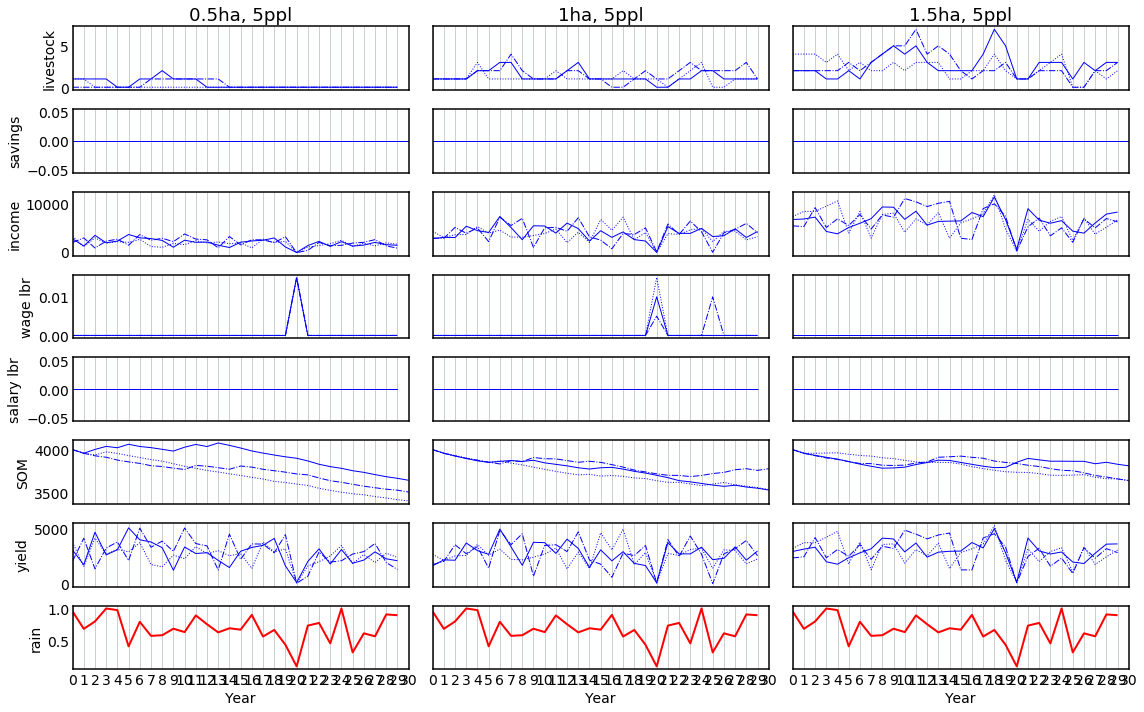

In [80]:
# livestock, wealth, income, % non-farm income (salary + wage), yield, som, rain
has = [0.5,1,1.5]
size = 5
num_plot = 3

fig, axs = plt.subplots(8,3,figsize=(16,10), sharex=True, sharey='row')
ax_flat = axs.flatten()
lss = [':','-','-.']
ag = m.agents
objs = [ag.livestock, ag.savings, ag.income, ag.wage_labor, ag.salary_labor, m.land.organic, m.land.yields]
names = ['livestock','savings','income','wage lbr','salary lbr','SOM','yield']
for h, ha in enumerate(has):
    ag_ix = np.arange(ag.N)[((ag.land_area==ha) * (ag.hh_size==size))][0:num_plot]

    for o, obj in enumerate(objs):
        for i, ix in enumerate(ag_ix):
            axs[o,h].plot(obj[:,ix], ls=lss[i], lw=1, color='b')
        # format
        if h==0:
            axs[o,h].set_ylabel(names[o])
        if o==0:
            axs[o,h].set_title('{}ha, {}ppl'.format(ha, size))
    axs[-1,h].plot(m.climate.rain, color='r')
    axs[-1,0].set_ylabel('rain')
    axs[-1,h].set_xticks(np.arange(m.T+1))
    axs[-1,h].set_xlim([0, m.T])
    axs[-1,h].set_xlabel('Year')

for ax in ax_flat:
    ax.grid(which='major', axis='y')#, linestyle='--')

fig.savefig('../../outputs/{}/baseline_single_agent.png'.format(exp_name),dpi=300)

## general plots

In [81]:
# fig, ax = plt.subplots()
# ax.plot(m.agents.crop_production[:,-1]/1000)
# ax.plot(m.agents.ls_start[:,-1], color='k')

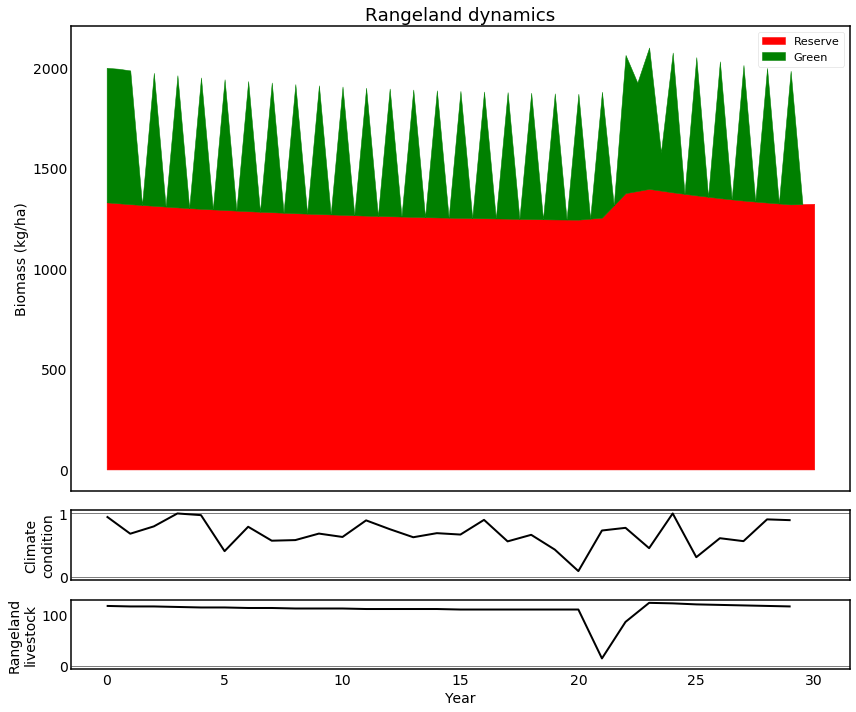

In [82]:
## plot the rangeland states
fig, axs = plt.subplots(3,1,figsize=(12,10),sharex=True, gridspec_kw={'height_ratios':[1,0.15,0.15]})
ax = axs[0]
# reserve biomass
ax.fill_between(np.arange(m.T+1), 0, m.rangeland.R, color='red', label='Reserve')
# format the green biomass
G = np.full([2*m.T], np.nan)
G[np.arange(m.T)*2] = m.rangeland.G_no_cons
G[np.arange(m.T)*2+1] = m.rangeland.G[:-1]
mids = (m.rangeland.R[:-1] + m.rangeland.R[1:]) / 2
R_all = np.full(2*m.T, np.nan)
R_all[np.arange(m.T)*2] = m.rangeland.R[:-1]
R_all[np.arange(m.T)*2+1] = mids

R_base = np.repeat(m.rangeland.R[:-1],2)
ax.fill_between(np.arange(2*m.T)/2, R_all, R_all+G, color='green', label='Green')

ax.grid(False)
ax.set_ylabel('Biomass (kg/ha)')
ax.legend()
ax.set_title('Rangeland dynamics')

# add rainfall and livestock total
axs[1].plot(m.climate.rain, color='k')
axs[1].grid(False)
axs[1].set_ylabel('Climate\ncondition')
axs[1].axhline(0, color='k', lw=0.5)
axs[1].axhline(1, color='k', lw=0.5)

axs[2].plot(m.rangeland.livestock_supported, color='k')
axs[2].grid(False)
axs[2].set_ylabel('Rangeland\nlivestock')
axs[2].set_xlabel('Year')
axs[2].axhline(0, color='k',lw=0.5)

## plots with no agent types

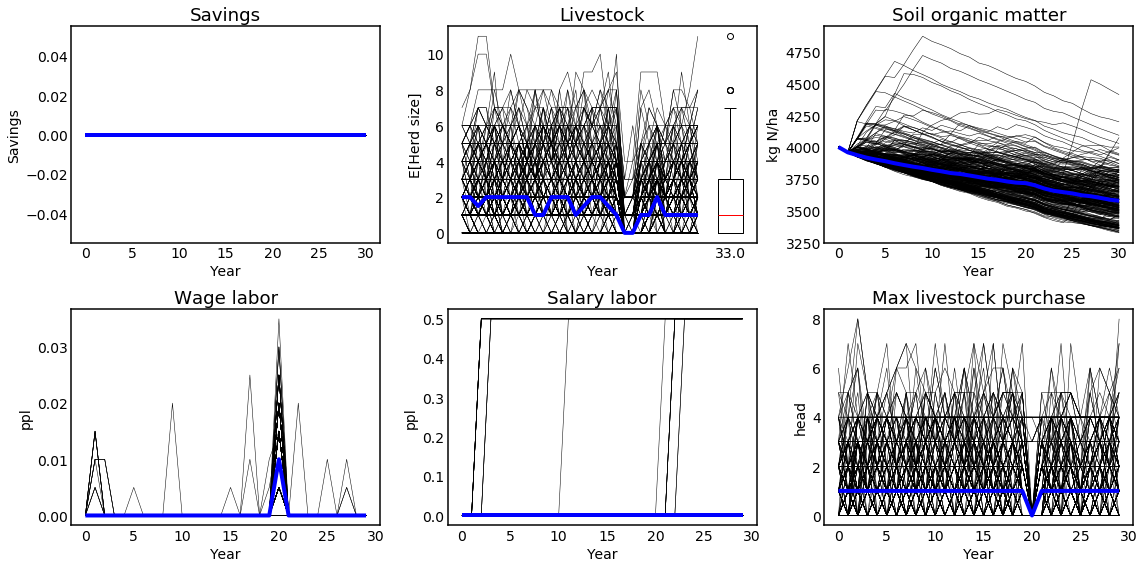

In [83]:
fig, axs = plt.subplots(2,3,figsize=(16,8))
axs = axs.flatten()

axs[0].plot(m.agents.savings, color='k', lw=0.5)
axs[0].plot(np.median(m.agents.savings, axis=1), color='b', lw=4)
axs[0].set_ylabel('Savings')
axs[0].set_title('Savings')

axs[1].plot(m.agents.livestock, color='k', lw=0.5)
axs[1].plot(np.median(m.agents.livestock, axis=1), color='b', lw=4)
axs[1].set_ylabel('E[Herd size]')
axs[1].set_title('Livestock')
axs[1].boxplot(m.agents.livestock[-1],positions=[m.T+m.T/10], widths=[int(m.T/10)])

axs[2].plot(m.land.organic, color='k', lw=0.5)
axs[2].plot(np.median(m.land.organic, axis=1), color='b', lw=4)
axs[2].set_ylabel('kg N/ha')
axs[2].set_title('Soil organic matter')

axs[3].plot(m.agents.wage_labor, color='k', lw=0.5)
axs[3].plot(np.median(m.agents.wage_labor, axis=1), color='b', lw=4)
axs[3].set_ylabel('ppl')
axs[3].set_title('Wage labor')

axs[4].plot(m.agents.salary_labor, color='k', lw=0.5)
axs[4].plot(np.median(m.agents.salary_labor, axis=1), color='b', lw=4)
axs[4].set_ylabel('ppl')
axs[4].set_title('Salary labor')

axs[5].plot(m.agents.max_ls_purchase, color='k', lw=0.5)
axs[5].plot(np.median(m.agents.max_ls_purchase, axis=1), color='b', lw=4)
axs[5].set_ylabel('head')
axs[5].set_title('Max livestock purchase')

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Year')

Text(0, 0.5, 'Frequency')

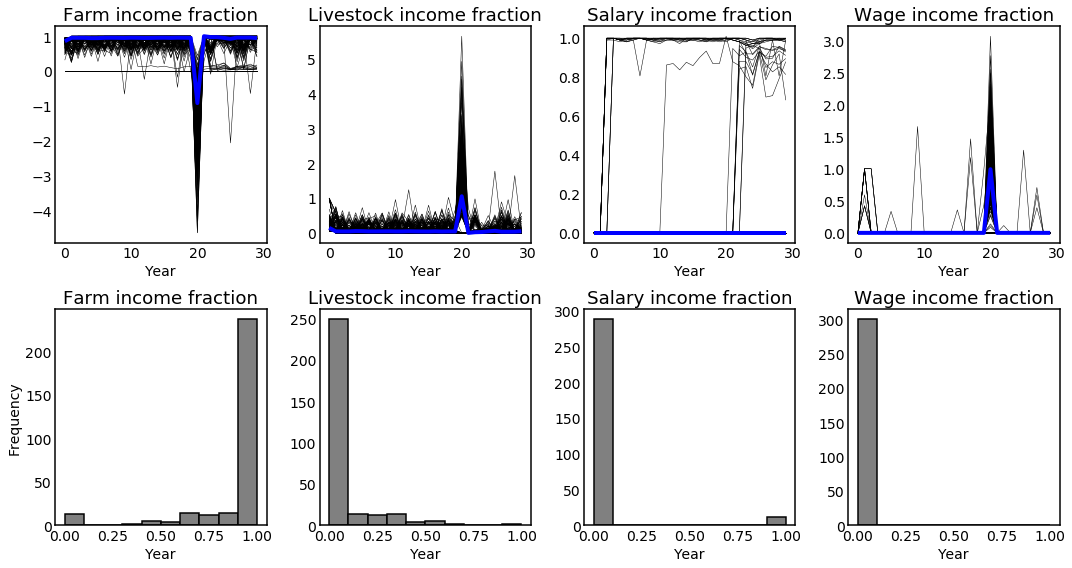

In [84]:
## agent income distribution
tplot = 10
bins = np.arange(0,1.1,0.1)
fig, axs = plt.subplots(2,4,figsize=(15,8))
objs = [m.agents.farm_income, m.agents.ls_income, m.agents.salary_income, m.agents.wage_income]
tot_income = np.sum(np.array(objs), axis=0)
titles = ['Farm income','Livestock income','Salary income', 'Wage income']
for o, obj in enumerate(objs):
    axs[0,o].plot(obj/tot_income, color='k',lw=0.5)
    axs[0,o].plot(np.nanmedian(obj/tot_income, axis=1), color='b',lw=4)
    axs[0,o].set_title(titles[o] + ' fraction')
    axs[0,o].set_xlabel('Year')
    axs[0,o].grid(False)
    
    axs[1,o].hist((obj/tot_income)[tplot], bins=bins, color='0.5', edgecolor='k', lw=1.5)
    axs[1,o].set_title(titles[o] + ' fraction')
    axs[1,o].set_xlabel('Year')
    axs[1,o].grid(False)
axs[1,0].set_ylabel('Frequency')

In [85]:
np.percentile(m.agents.crop_production, 20,axis=1)

array([ 856.6, 1087.4, 1124.2, 1031.8,  994. ,  863.6, 1003.2,  930.8,
        972.6,  853.2,  878.8,  909.8,  879.8,  855.8,  874.2,  939.4,
        828.4,  885.4,  898. ,  924. ,   10. ,  766.4,  854.2,  751.6,
        859.4,  659.6,  906.4,  804. ,  828.4,  818.6])

In [86]:
m.agents.ls_income.mean(axis=1)

array([635.        , 586.66666667, 686.66666667, 400.83333333,
       627.08333333, 586.66666667, 681.25      , 533.33333333,
       454.58333333, 552.91666667, 753.75      , 536.25      ,
       665.41666667, 541.66666667, 536.25      , 539.16666667,
       612.91666667, 577.5       , 647.5       , 536.25      ,
       290.        , 116.25      , 642.08333333, 185.41666667,
       367.5       , 375.41666667, 630.        , 653.75      ,
       346.25      , 507.5       ])

In [87]:
np.percentile(m.agents.herds_on_residue, [20,50,80], axis=1)

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. ],
       [3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. ,
        3. , 3. , 3. , 3. , 3. , 3. , 2.2, 0. , 1. , 2. , 2. , 3. , 2. ,
        3. , 3. , 3. , 3. ]])

In [100]:
m.agents.land_area

array([2.25, 0.5 , 1.5 , 2.  , 2.  , 1.5 , 0.75, 0.5 , 1.  , 2.5 , 2.  ,
       0.25, 0.75, 1.  , 1.  , 2.  , 1.  , 1.25, 1.  , 1.  , 0.5 , 3.  ,
       1.25, 2.5 , 3.5 , 0.5 , 0.25, 1.  , 1.25, 1.  , 2.  , 1.  , 0.25,
       1.5 , 0.5 , 1.  , 1.5 , 1.75, 0.5 , 0.5 , 1.  , 3.  , 0.25, 2.  ,
       2.5 , 2.  , 1.  , 1.  , 0.5 , 2.  , 1.5 , 1.  , 0.25, 1.  , 0.5 ,
       1.5 , 2.5 , 0.5 , 1.  , 0.5 , 1.  , 1.  , 1.  , 2.5 , 1.  , 1.  ,
       2.  , 2.5 , 0.5 , 1.  , 0.  , 0.5 , 0.25, 0.5 , 1.  , 0.5 , 1.5 ,
       2.  , 1.25, 2.5 , 0.5 , 3.  , 0.75, 1.  , 0.5 , 2.5 , 0.  , 0.25,
       0.75, 2.5 , 0.5 , 1.  , 0.25, 1.25, 0.75, 1.25, 1.5 , 3.  , 1.5 ,
       1.5 , 2.  , 0.75, 1.  , 1.5 , 0.5 , 0.5 , 2.  , 1.5 , 1.5 , 1.  ,
       2.5 , 0.75, 2.5 , 0.75, 0.25, 0.5 , 2.  , 1.5 , 2.  , 1.5 , 0.5 ,
       1.5 , 0.  , 1.75, 1.25, 0.5 , 0.25, 1.5 , 2.  , 1.5 , 1.5 , 0.25,
       1.5 , 0.  , 2.75, 1.25, 0.75, 1.75, 0.5 , 2.  , 1.  , 0.5 , 2.  ,
       0.5 , 0.5 , 2.  , 0.25, 1.  , 1.  , 1.75, 0.

In [103]:
m.agents.livestock[5]

array([4, 0, 2, 3, 2, 6, 0, 0, 1, 5, 3, 0, 0, 2, 1, 3, 2, 4, 2, 2, 0, 5,
       1, 3, 6, 0, 0, 1, 1, 1, 3, 1, 0, 1, 0, 1, 4, 2, 0, 1, 3, 4, 1, 1,
       4, 6, 1, 0, 0, 4, 2, 1, 0, 2, 0, 3, 5, 0, 2, 0, 2, 1, 2, 4, 1, 2,
       4, 3, 0, 1, 0, 3, 0, 0, 2, 0, 3, 3, 1, 5, 0, 6, 0, 1, 0, 4, 0, 0,
       2, 5, 0, 2, 0, 2, 0, 2, 3, 4, 2, 1, 3, 1, 1, 4, 0, 0, 3, 1, 1, 1,
       4, 2, 3, 2, 0, 0, 4, 3, 3, 3, 0, 2, 0, 3, 2, 0, 0, 3, 2, 2, 1, 0,
       2, 0, 5, 3, 1, 4, 0, 1, 1, 0, 6, 0, 0, 4, 0, 2, 2, 5, 1, 3, 2, 1,
       0, 1, 1, 4, 5, 1, 2, 2, 2, 2, 4, 4, 3, 0, 2, 5, 1, 3, 2, 3, 0, 0,
       2, 1, 3, 2, 0, 1, 4, 7, 0, 1, 1, 5, 0, 0, 3, 1, 0, 1, 6, 0, 1, 0,
       0, 3, 2, 0, 0, 2, 7, 0, 3, 1, 5, 1, 6, 0, 2, 3, 1, 6, 0, 0, 2, 0,
       4, 5, 1, 2, 1, 6, 0, 3, 3, 6, 8, 2, 2, 2, 0, 2, 0, 6, 1, 2, 1, 0,
       0, 3, 0, 1, 7, 3, 0, 0, 2, 2, 5, 1, 4, 3, 0, 3, 2, 2, 2, 0, 2, 0,
       0, 0, 0, 2, 0, 3, 2, 0, 2, 6, 0, 0, 5, 0, 1, 1, 3, 7, 0, 6, 1, 3,
       4, 2, 2, 1, 2, 0, 1, 2, 1, 5, 2, 0, 3, 3])

In [99]:
m.agents.herds_on_residue[5]

array([4, 0, 1, 2, 2, 3, 0, 0, 1, 5, 3, 0, 0, 2, 1, 3, 2, 2, 1, 0, 0, 5,
       1, 2, 6, 0, 0, 1, 1, 1, 3, 1, 0, 1, 0, 1, 4, 1, 0, 0, 2, 4, 0, 1,
       4, 6, 1, 0, 0, 4, 2, 1, 0, 2, 0, 2, 5, 0, 2, 0, 2, 0, 2, 3, 1, 1,
       4, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 3, 1, 5, 0, 4, 0, 1, 0, 4, 0, 0,
       1, 4, 0, 2, 0, 2, 0, 1, 3, 4, 2, 1, 3, 1, 1, 4, 0, 0, 3, 1, 1, 1,
       4, 1, 3, 1, 0, 0, 4, 3, 1, 3, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0,
       2, 0, 5, 1, 1, 3, 0, 1, 1, 0, 3, 0, 0, 4, 0, 0, 2, 3, 0, 2, 2, 1,
       0, 1, 1, 4, 5, 1, 1, 2, 1, 0, 3, 2, 3, 0, 2, 5, 0, 1, 2, 1, 0, 0,
       1, 1, 3, 2, 0, 1, 3, 7, 0, 0, 1, 5, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0,
       0, 3, 1, 0, 0, 2, 5, 0, 3, 1, 5, 1, 4, 0, 2, 1, 0, 5, 0, 0, 2, 0,
       3, 3, 1, 2, 1, 6, 0, 1, 2, 6, 7, 1, 2, 1, 0, 2, 0, 3, 1, 2, 0, 0,
       0, 3, 0, 0, 6, 1, 0, 0, 2, 2, 5, 1, 4, 1, 0, 1, 1, 2, 1, 0, 2, 0,
       0, 0, 0, 1, 0, 3, 1, 0, 2, 6, 0, 0, 4, 0, 1, 1, 2, 7, 0, 5, 0, 1,
       3, 2, 2, 1, 2, 0, 1, 2, 1, 5, 1, 0, 3, 2])

In [93]:
np.percentile(m.agents.herds_on_rangeland, [20,50,80], axis=1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.]])

In [97]:
m.rangeland.size_ha

346.25319314508545

(array([3.416e+03, 2.104e+03, 1.574e+03, 8.530e+02, 5.650e+02, 2.860e+02,
        1.420e+02, 4.300e+01, 1.400e+01, 3.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

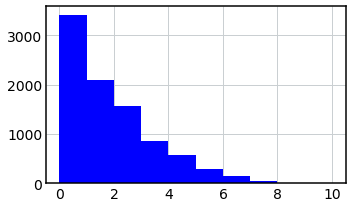

In [88]:
fig,ax = plt.subplots(figsize=(5,3))
# ax.hist(m.agents.land_area)
ax.hist(m.agents.herds_on_residue.flatten())

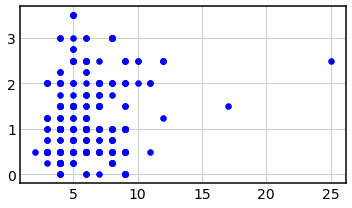

In [89]:
fig,ax = plt.subplots(figsize=(5,3))
# ax.hist(m.agents.land_area)
ax.scatter(m.agents.hh_size,m.agents.land_area)

In [90]:
m.all_inputs['livestock']['consumption']

2001.0

Text(0, 0.5, 'Frequency')

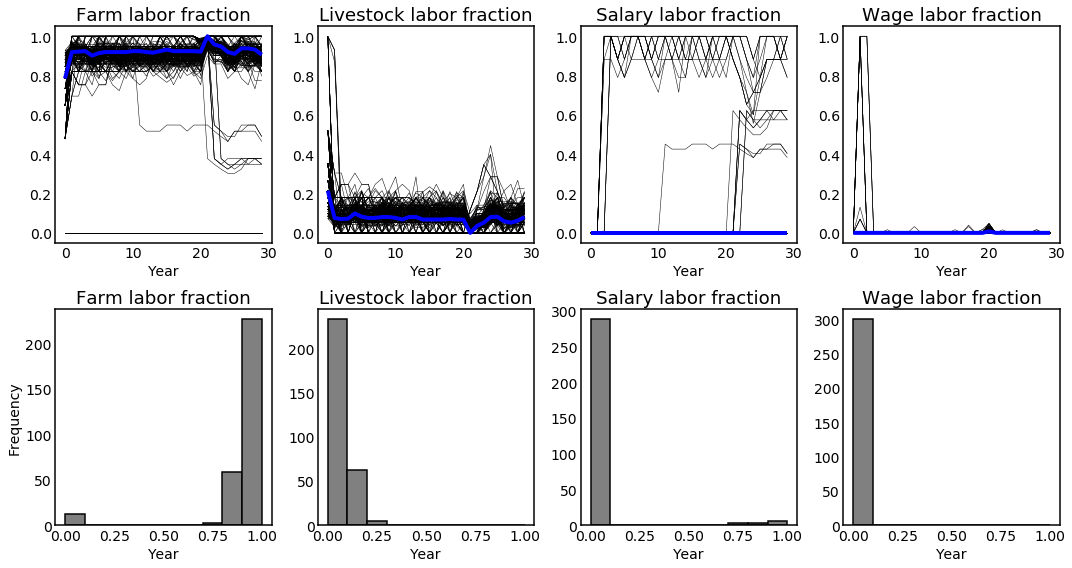

In [91]:
## agent labor distribution
tplot = 10
bins = np.arange(0,1.1,0.1)
fig, axs = plt.subplots(2,4,figsize=(15,8))
objs = [m.agents.ag_labor, m.agents.ls_labor, m.agents.salary_labor, m.agents.wage_labor]
tot_labor = np.sum(np.array(objs), axis=0)
titles = ['Farm labor','Livestock labor','Salary labor', 'Wage labor']
for o, obj in enumerate(objs):
    axs[0,o].plot(obj/tot_labor, color='k',lw=0.5)
    axs[0,o].plot(np.nanmedian(obj/tot_labor, axis=1), color='b',lw=4)
    axs[0,o].set_title(titles[o] + ' fraction')
    axs[0,o].set_xlabel('Year')
    axs[0,o].grid(False)
    
    axs[1,o].hist((obj/tot_labor)[tplot], bins=bins, color='0.5', edgecolor='k', lw=1.5)
    axs[1,o].set_title(titles[o] + ' fraction')
    axs[1,o].set_xlabel('Year')
    axs[1,o].grid(False)
axs[1,0].set_ylabel('Frequency')

In [43]:
# plt.scatter(m.agents.land_area, m.agents.livestock[-1])
# plt.scatter(m.agents.hh_size, m.agents.livestock[-1])

In [44]:
m.agents.max_ls_purchase.max()

8.0

## plots with agent types


In [ ]:
print(m.agents.ls_start[10, 0:10])
print(m.agents.ls_reprod[10, 0:10])
print(m.agents.ls_destock[10, 0:10])
print(m.agents.ls_stress[10, 0:10])

In [ ]:
## livestock
fig, ax = plt.subplots(figsize=(12,7))
# format data
ls = np.full([4*m.T, m.n_agents], np.nan)
ls[4*np.arange(m.T)] = m.agents.ls_start
ls[4*np.arange(m.T)+1] = m.agents.ls_reprod
ls[4*np.arange(m.T)+2] = m.agents.ls_destock
ls[4*np.arange(m.T)+3] = m.agents.ls_stress

t = np.arange(ls.shape[0])/4
colors = {1:'k',1.5:'r',2:'b'}
labls = []

for a in range(m.n_agents):
    land = m.agents.land_area[a]
    lgd = '_nolegend_' if land in labls else '{} ha'.format(land)
    labls.append(land)  
    ax.plot(t,ls[:,a], color=colors[land], label=lgd)
    
ax.legend()
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel('Number of livestock')
ax.set_title('Livestock by agent type')

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
colors = {1:'k',1.5:'r',2:'b'}
labls = []

for a in range(m.n_agents):
    land = m.agents.land_area[a]
#     if land == 1.5:
    lgd = '_nolegend_' if land in labls else '{} ha'.format(land)
    labls.append(land)  
    ax.plot(m.agents.wealth[:,a], color=colors[land], label=lgd)
    
ax.legend()
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel('Total wealth')
ax.set_title('Wealth by agent type')
ax.grid(False)

In [ ]:
import plot.ins_cc.single_run as single_run
single_run.separate(m)

In [ ]:
single_run.type_yields(m, False)

## POM

In [ ]:
    
mod=m  
n_yrs = 10
p_cope = np.mean(mod.agents.cons_red_rqd[-n_yrs:])
one = True if ((p_cope>=0.3) & (p_cope<=0.45)) else False
#### NOTE: REMOVING THIS ONE BECAUSE IT CONFLICTS WITH THE WAGE AND SALARY REQUIREMENTS AND LIVESTOCK
#### (IE HAVING 30-45% OF PEOPLE NEEDING TO COPE BUT >80% WITH LIVESTOCK AND <15% WITH WAGE IS ROUGH)
print('one')
print(one)

## 2. land degradation exists
# not consistently someone at maximum value
# (this is calculated over TIME, not a single AGENT that's at max) 
maxs = np.max(mod.land.organic[-n_yrs:], axis=1)
two = False if max(maxs) == mod.land.max_organic_N else True
print('two')
print(two)

## 3. rangeland is not fully degrated
## A: P(regional destocking required) \in [0.1,0.5]
prob = np.mean(mod.rangeland.destocking_rqd)
threeA = True if ((prob >= 0) and (prob <= 0.5)) else False
## B: min(reserve biomass) > 0.2*R_max
threeB = True if min(mod.rangeland.R >= 0.2 * mod.rangeland.R_max) else False
## C: there are livestock on the rangeland in the last n_yrs
# threeC = True if (min(mod.rangeland.livestock_supported[-n_yrs:]) > 0) else False
three = bool(threeA * threeB)
print('three')
print(three)

## 4. livestock: 
# >80% of HHs have livestock on average
fourA = np.mean(mod.agents.livestock[-n_yrs:]>0) >= 0.8
# 90th%ile agent has less than 10 livestock on average
fourB = np.percentile(np.mean(mod.agents.livestock, axis=0), 90) < 10 # take mean over time for each agent
# median agent has less than 5 on average
fourC = np.percentile(np.mean(mod.agents.livestock, axis=0), 50) < 5
# maximum ever is less than 50
fourD = np.max(mod.agents.livestock)<50
four = bool(fourA*fourB*fourC*fourD)
# four = bool(fourA*fourB*fourD)
print('four')
print(fourA)
print(fourB)
print(fourC)
print(fourD)

## 5. non-farm income
# upper and lower limits on wage and salary income
p_wage = np.mean(mod.agents.wage_labor[-n_yrs:] > 0)
p_sal = np.mean(mod.agents.salary_labor[-n_yrs:] > 0)
# print(p_sal)
fiveA = ((p_wage>0.05) & (p_wage<0.15))
fiveB = ((p_sal>0.05) & (p_sal<0.15))
# fiveA = ((p_wage>0.1) & (p_wage<0.15))
# fiveB = ((p_sal>0.05) & (p_sal<0.1))
# code.interact(local=dict(globals(), **locals()))
five = bool(fiveA*fiveB)
print(p_wage)
print(p_sal)

In [ ]:
for r in range(10):
    inputs['model']['seed'] = r
    m = mod_code.Model(inputs)
    for t in range(m.T):
        m.step()
    
    mod = m
    n_yrs = 10
#     fits.append(POM.fitting_metrics(m))

    p_cope = np.mean(mod.agents.cons_red_rqd[-n_yrs:])
    one = True if ((p_cope>=0.3) & (p_cope<=0.45)) else False
    #### NOTE: REMOVING THIS ONE BECAUSE IT CONFLICTS WITH THE WAGE AND SALARY REQUIREMENTS AND LIVESTOCK
    #### (IE HAVING 30-45% OF PEOPLE NEEDING TO COPE BUT >80% WITH LIVESTOCK AND <15% WITH WAGE IS ROUGH)

    ## 2. land degradation exists
    # not consistently someone at maximum value
    # (this is calculated over TIME, not a single AGENT that's at max) 
    maxs = np.max(mod.land.organic[-n_yrs:], axis=1)
    two = False if max(maxs) == mod.land.max_organic_N else True

    ## 3. rangeland is not fully degrated
    ## A: P(regional destocking required) \in [0.1,0.5]
    prob = np.mean(mod.rangeland.destocking_rqd)
    threeA = True if ((prob >= 0) and (prob <= 0.5)) else False
    ## B: min(reserve biomass) > 0.2*R_max
    threeB = True if min(mod.rangeland.R >= 0.2 * mod.rangeland.R_max) else False
    ## C: there are livestock on the rangeland in the last n_yrs
    # threeC = True if (min(mod.rangeland.livestock_supported[-n_yrs:]) > 0) else False
    three = bool(threeA * threeB)

    ## 4. livestock: 
    # >80% of HHs have livestock on average
    fourA = np.mean(mod.agents.livestock[-n_yrs:]>0) >= 0.8
    # 90th%ile agent has less than 10 livestock on average
    fourB = np.percentile(np.mean(mod.agents.livestock, axis=0), 90) < 10 # take mean over time for each agent
    # median agent has less than 5 on average
    fourC = np.percentile(np.mean(mod.agents.livestock, axis=0), 50) < 5
    # maximum ever is less than 50
    fourD = np.max(mod.agents.livestock)<50
    four = bool(fourA*fourB*fourC*fourD)
    # four = bool(fourA*fourB*fourD)

    ## 5. non-farm income
    # upper and lower limits on wage and salary income
    p_wage = np.mean(mod.agents.wage_labor[-n_yrs:] > 0)
    p_sal = np.mean(mod.agents.salary_labor[-n_yrs:] > 0)
    # print(p_sal)
    fiveA = ((p_wage>0.05) & (p_wage<0.15))
    fiveB = ((p_sal>0.05) & (p_sal<0.15))
    # fiveA = ((p_wage>0.1) & (p_wage<0.15))
    # fiveB = ((p_sal>0.05) & (p_sal<0.1))
    # code.interact(local=dict(globals(), **locals()))
    five = bool(fiveA*fiveB)

#     print(p_sal)
    print(p_wage)

# old stuff

In [ ]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm')
sys.path.append('../')
import model.model as mod_code
import experiments.POM as POM
import plot.single_run as plt_single
import imp
import numpy as np
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [ ]:
f = '../../outputs/2019_10_15_4/POM/100000_10reps/input_params_0.pkl'
f = '../../outputs/2020_1_27_savings/POM/100000_10reps/input_params_0.pkl'
inputs = pickle.load(open(f, 'rb'))
inputs['adaptation']['burnin_period'] = 10

In [ ]:
inputs['model']['seed'] = 0
inputs['model']['T'] = 100
# inputs['agents']['wealth_init_mean'] *=1
# inputs['land']['random_effect_sd'] = 0.5
inputs['model']['n_agents'] = 60
inputs['agents']['land_area_multiplier'] = 1


# inputs['land']['wealth_N_conversion'] *= 0.9
# inputs['land']['organic_N_min_init'] = 6000
# inputs['land']['organic_N_max_init'] = 6000
# inputs['agents']['cash_req_mean'] *= 1.3
# inputs['land']['random_effect_sd'] = 0.1

# inputs['model']['adaptation_option'] = 'cover_crop'
# inputs['agents']['adap_type'] = 'always'
inputs['rangeland']['R0_frac'] = 0.3

In [ ]:
# m = mod_code.Model(inputs)
# for t in range(m.T):
#     m.step()

In [ ]:
# imp.reload(plt_single)
# plt_single.main(m, save=False)

In [ ]:
# # assess variability in yields
# print(m.land.yields.shape)
# ags = m.agents.land_area == 1.5
# o1 = np.mean(np.var(m.land.yields[:,ags], axis=0))
# o2 = np.mean(np.var(m.land.yields[:,ags], axis=1))
# print('agent variance is this fraction of annual variance')
# print(o2/o1)

LSMS

In [32]:
lsms = pd.read_csv('../../data/LSMS/ethiopia_2015_formatted.csv', index_col=0)

In [33]:
lsms.head()

,fs,hh_age,hh_sex,hh_size,dr,floor,credit,area,cropdiv,number_lv,dist_market,af_bio_1,h2015_tot,rain_dev,agprod,fert_per_area,iddir,market_orient,income_cat,rgnname
1,0,37,1,9,2.0,0,0,6.261924,5,4,105,264,1272,573,3.1840,0.000000,0,0.33,0,Tigray
2,0,30,0,3,0.5,0,0,0.005127,1,0,105,264,1272,573,0.0030,0.000000,0,0.00,0,Tigray
3,0,30,0,4,3.0,0,0,0.109257,2,2,105,264,1272,573,0.0065,54.916390,0,0.00,0,Tigray
4,0,41,1,5,1.5,1,0,0.012235,1,15,105,264,1272,573,0.0400,0.000000,0,0.00,1,Tigray
5,0,35,1,5,1.5,0,1,4.215987,5,23,105,264,1272,573,1.9550,11.859619,0,0.24,0,Tigray


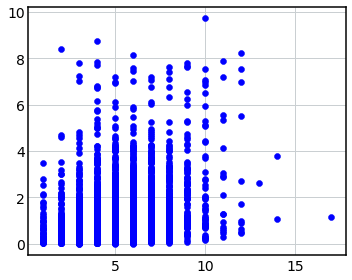

In [35]:
fig,ax= plt.subplots(figsize=(5,4))
lsms2 = lsms[lsms.area < 10]
ax.scatter(lsms2.hh_size, lsms2.area)

(0, 1)

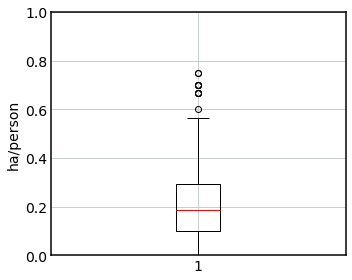

In [43]:
fig,ax=plt.subplots(figsize=(5,4))
# ax.boxplot(lsms2.area/lsms2.hh_size)
ax.boxplot(m.agents.land_area/m.agents.hh_size)
ax.set_ylabel('ha/person')
ax.set_ylim([0,1])

In [48]:
d = np.array([3,4,5])
(d < 5) | (d<4)

array([ True,  True, False])